#**Getting data**

In [49]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [50]:
from torchvision.datasets.mnist import FashionMNIST
train_dataset= datasets.FashionMNIST(root= "data", train=True, #train_data
                               download=True,
                               transform=ToTensor(), #transform to convert image to tensor
                               target_transform=None) #transformation on labels

test_dataset= datasets.FashionMNIST(root="data",
                                    train=False, #tets_data
                                    transform=ToTensor(),
                                    target_transform=None)

In [51]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [52]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [53]:
image, label= train_dataset[0] #IMP: PYTORCH SUPPORTS C*H*W PATTERN HERE CHANNELS COME FIRST
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [54]:
#train_dataset[0][:1] #gives tuples of img, label

In [55]:
class_names=train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [56]:
class_to_idx= train_dataset.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [57]:
train_dataset.targets, train_dataset.targets.shape

(tensor([9, 0, 0,  ..., 3, 0, 5]), torch.Size([60000]))

##**Visualising data**

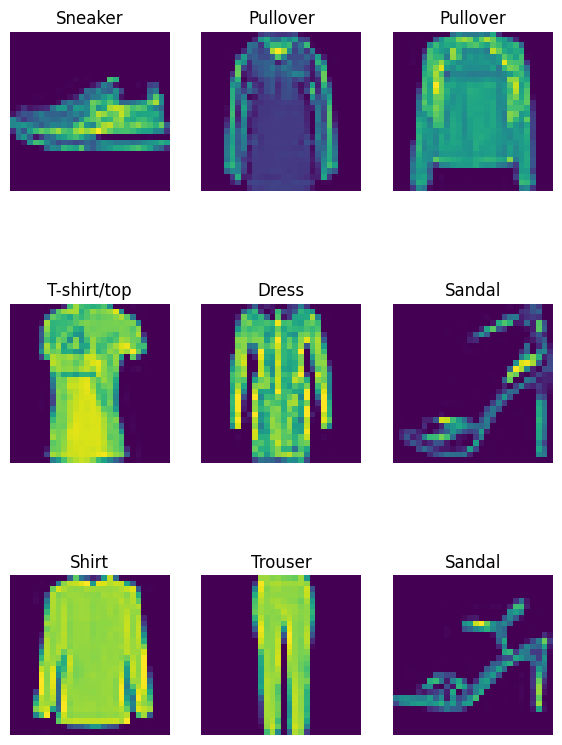

In [58]:
import random

r, c= 3, 3
plt.figure(figsize=(7, 10))
for i in range( 1, 1+r*c):

  rand_idx= random.randint(0, len(train_dataset))

  plt.subplot(3,3,i)
  img, label= train_dataset[rand_idx]
  plt.imshow(img.squeeze()) #img shape=[1,28,28] we need to remve the color channel dim in 0th pos 
  plt.title(f"{class_names[label]}")
  plt.axis("off")

##**Loading data**

**Batching**:
* it is computaionally more efficient, as our computer might not be able to look at all the data at once
* it gives our model more chances to update its weights, ie it can now update its weights after every batch instead of looking at the entire data.

In [59]:
train_dataset=torch.utils.data.DataLoader(dataset= train_dataset,
                                         batch_size=32,
                                         shuffle=True)

test_dataset=torch.utils.data.DataLoader(dataset= test_dataset,
                                         batch_size= 32,
                                         shuffle=False)

In [60]:
train_dataset, test_dataset

(<torch.utils.data.dataloader.DataLoader at 0x7fcadaf711c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcadaf71d00>)

In [61]:
imgs, labels= next(iter(train_dataset))
imgs.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#**Model_0:**Dense

In [62]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [63]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exists, skipping download!")
else:
  print("downloading helper functions.py")
  file_r= requests.get("https://raw.githubusercontent.com/Jothish2283/DeepLearning-Torch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(file_r.content)

already exists, skipping download!


In [64]:
model_0=torch.nn.Sequential(nn.Flatten(),
                            nn.Linear(28*28, 64),
                            nn.ReLU(),
                            nn.Linear(64,64),
                            nn.ReLU(),
                            nn.Linear(64,64),
                            nn.ReLU(),
                            nn.Linear(64,len(class_names)),
                            nn.Softmax()).to(device)
model_0

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): Softmax(dim=None)
)

In [65]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_0.parameters())

##**Training Loop**

In [66]:
import time
from tqdm.auto import tqdm #to get a progress bar
from helper_functions import accuracy_fn

epochs=5

start=time.time()
for epoch in tqdm(range(epochs)):
  print(f"---Epoch:{epoch+1}---\n")
  train_loss, train_acc=0, 0
  for x, y in train_dataset:

    model_0.train()
    y_preds=model_0(x.to(device))

    loss= loss_fn(y_preds, y.to(device))
    acc=accuracy_fn(y.to(device), y_preds.argmax(dim=1))

    train_loss=loss.item()+train_loss
    train_acc= acc+train_acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  
  avg_loss_per_epoch= train_loss/len(train_dataset)
  avg_acc_per_epoch= train_acc/(len(train_dataset)*100)
  print(f"train_loss:{avg_loss_per_epoch :.3f} train_acc:{avg_acc_per_epoch :.3f}")

  test_loss, test_acc=0, 0
  model_0.eval()
  with torch.inference_mode():
    for x_t, y_t in test_dataset:
      y_preds_t=model_0(x_t.to(device))

      loss=loss_fn(y_preds_t, y_t.to(device))
      acc=accuracy_fn(y_t.to(device), y_preds_t.argmax(dim=1))

      test_loss=test_loss+loss.item()
      test_acc=test_acc+acc
    
    avg_loss_per_epoch= test_loss/(len(test_dataset))
    avg_acc_per_epoch= test_acc/(len(test_dataset)*100)
    
    print(f"test_loss:{avg_loss_per_epoch :.3f} test_acc:{avg_acc_per_epoch :.3f}\n")

end=time.time()
model_0_time=(end-start)/60
print(f"time taken= {model_0_time :.2f} mins")

  0%|          | 0/5 [00:00<?, ?it/s]

---Epoch:1---



/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_loss:1.743 train_acc:0.724
test_loss:1.710 test_acc:0.752

---Epoch:2---

train_loss:1.689 train_acc:0.772
test_loss:1.693 test_acc:0.767

---Epoch:3---

train_loss:1.678 train_acc:0.783
test_loss:1.682 test_acc:0.779

---Epoch:4---

train_loss:1.673 train_acc:0.788
test_loss:1.688 test_acc:0.772

---Epoch:5---

train_loss:1.668 train_acc:0.793
test_loss:1.678 test_acc:0.782

time taken= 1.36 mins


**Evaluation**

In [67]:
def eval_model(model: torch.nn.Module,
              test_dataset: torch.utils.data.DataLoader= test_dataset,
              loss_fn: torch.nn.Module = loss_fn,
              acc_fn= accuracy_fn):
   
  acc, loss=0, 0
  model.to("cpu")
  with torch.inference_mode():
    for x, y in tqdm(test_dataset):
      x, y= x.cpu(), y.cpu()
      y_preds=model(x)
      loss+=loss_fn(y_preds, y)
      acc+=acc_fn(y, y_preds.argmax(dim=1))
    loss/=len(test_dataset)
    acc/=len(test_dataset)

    return {"val_loss":loss.item(), "val_acc":acc}

In [68]:
model_0_res=eval_model(model_0)
model_0_res

  0%|          | 0/313 [00:00<?, ?it/s]

{'val_loss': 1.6783480644226074, 'val_acc': 78.15495207667732}

#**Model_1:** CNN

In [69]:
model_1= torch.nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2),
                             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2),
                             nn.Flatten(),
                             nn.Linear(in_features=400, out_features=len(class_names)),
                             nn.Softmax()).to(device)

model_1

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=10, bias=True)
  (10): Softmax(dim=None)
)

In [70]:
loss_fn=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_1.parameters())

##**Training Loop**

In [71]:
epochs=5
train_loss, acc=0, 0

start=time.time()
for epoch in tqdm(range(epochs)):
  
  print(f"---epoch:{epoch+1}---\n")
  model_1.train()
  for x, y in train_dataset:
    x, y= x.to(device), y.to(device)
    y_preds=model_1(x)

    loss=loss_fn(y_preds, y)

    train_loss+=loss.item()
    acc+=accuracy_fn(y, y_preds.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  avg_loss=train_loss/len(train_dataset)
  avg_acc=acc/len(train_dataset)
  print(f"train_loss:{avg_loss :.4f} train_acc:{avg_acc/100 :.3f}")

  loss, acc= 0, 0

  model_1.eval()

  with torch.inference_mode():

    for x, y in test_dataset:
      x, y= x.to(device), y.to(device)
      y_preds=model_1(x)

      loss+=loss_fn(y_preds, y).item()
      acc+=accuracy_fn(y, y_preds.argmax(dim=1))
    
    avg_loss=loss/len(test_dataset)
    avg_acc= acc/len(test_dataset)
    print(f"val_loss:{avg_loss :.4f} val_acc:{avg_acc/100 :.3f}\n")

end=time.time()
model_1_time=(end-start)/60
print(f"Time taken:{model_1_time :.2f} mins")

  0%|          | 0/5 [00:00<?, ?it/s]

---epoch:1---

train_loss:1.7210 train_acc:0.743
val_loss:1.6680 val_acc:0.794

---epoch:2---

train_loss:3.3735 train_acc:0.941
val_loss:1.6548 val_acc:0.807

---epoch:3---

train_loss:5.0138 train_acc:0.956
val_loss:1.6406 val_acc:0.821

---epoch:4---

train_loss:6.6334 train_acc:0.979
val_loss:1.6076 val_acc:0.853

---epoch:5---

train_loss:8.2286 train_acc:1.008
val_loss:1.6008 val_acc:0.861

Time taken:3.76 mins


**Evaluation**

In [72]:
model_1_res=eval_model(model_1)
model_1_res

  0%|          | 0/313 [00:00<?, ?it/s]

{'val_loss': 1.6008062362670898, 'val_acc': 86.10223642172524}

#**Visualising results**

In [73]:
test_dataset= datasets.FashionMNIST(root="data",
                                    train=False, #tets_data
                                    transform=ToTensor(),
                                    target_transform=None)

test_dataset=torch.utils.data.DataLoader(dataset= test_dataset,
                                         batch_size= 32,
                                         shuffle=False)

In [74]:
import random

def view_res(model):
  rand_batch=random.randint(1, len(test_dataset))
  rand_idx=random.randint(1, 32-9) #from that index we r gonna take the next 9 samples
  for batch, (x,y) in enumerate(test_dataset):
    if batch==rand_batch:
      test_img=x[rand_idx:rand_idx+9,:,:]
      test_labels=y[rand_idx:rand_idx+9]

      model.eval()
      
      with torch.inference_mode():
        y_preds_s=model(test_img)
        y_preds=y_preds_s.argmax(dim=1)
        y_preds=y_preds.numpy()
        y=y.numpy()
        prob=torch.max(y_preds_s,dim=1)

      plt.figure(figsize=(13,13))
      for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(test_img[i].squeeze())
        plt.axis("off")
        
        if y_preds[i]==y[i+rand_idx]:
          plt.title(f"true_class:{class_names[y[rand_idx+i]]}\npred_class:{class_names[y_preds[i]]}\nprob:{prob[0][i] :.2f}", c="g", fontsize=8)
        else:
          plt.title(f"true_class:{class_names[y[i+rand_idx]]}\npred_class:{class_names[y_preds[i]]}\nprob:{prob[0][i] :.2f}", c="r", fontsize=8)
      plt.show()

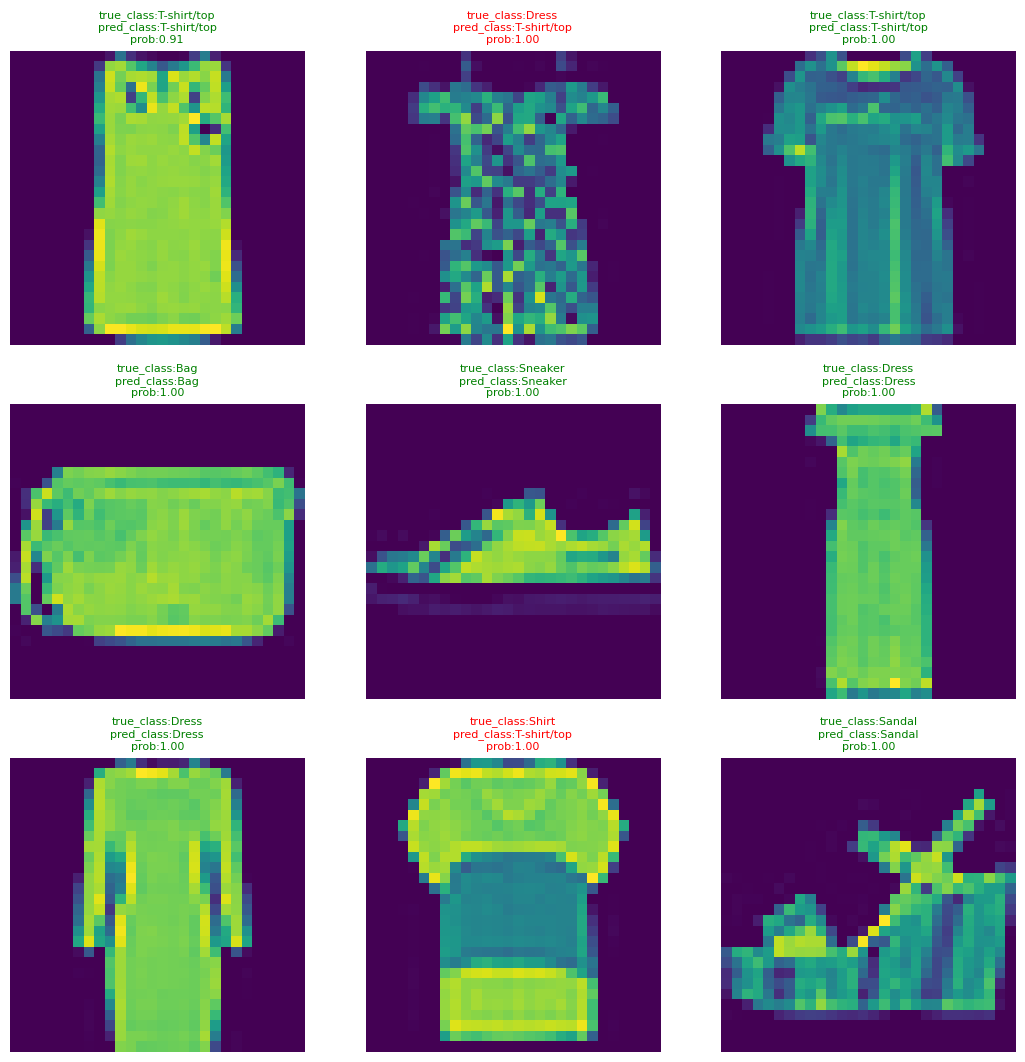

In [75]:
view_res(model_0)

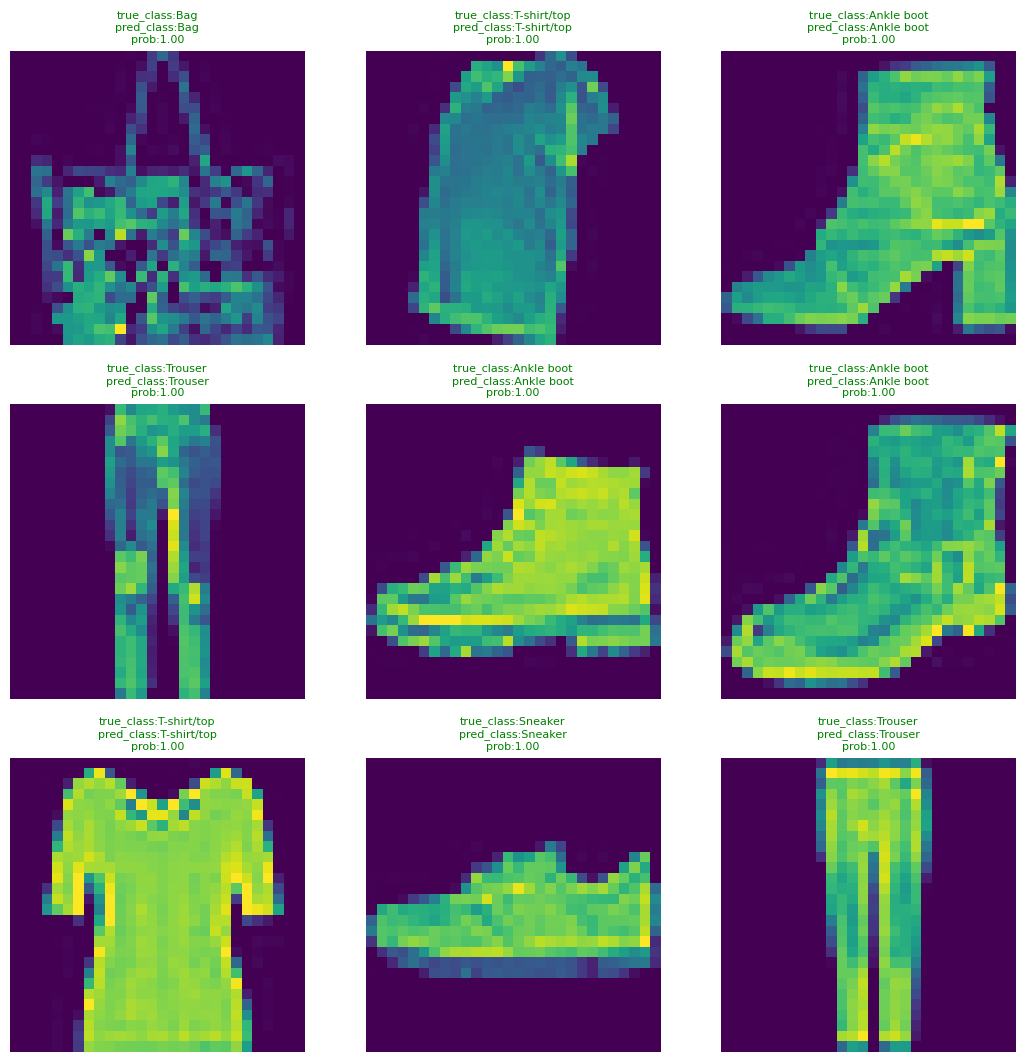

In [76]:
view_res(model_1)

#**Conclusion**

In [77]:
import pandas as pd
df=pd.DataFrame([model_0_res, model_1_res])
df["model_name"]=["model_0 [Dense]", "model_1[CNN]"]
df["time [mins]"]=[model_0_time, model_1_time]
df=df.set_index("model_name")
df

,val_loss,val_acc,time [mins]
model_name,,,
model_0 [Dense],1.678348,78.154952,1.361833
model_1[CNN],1.600806,86.102236,3.758875


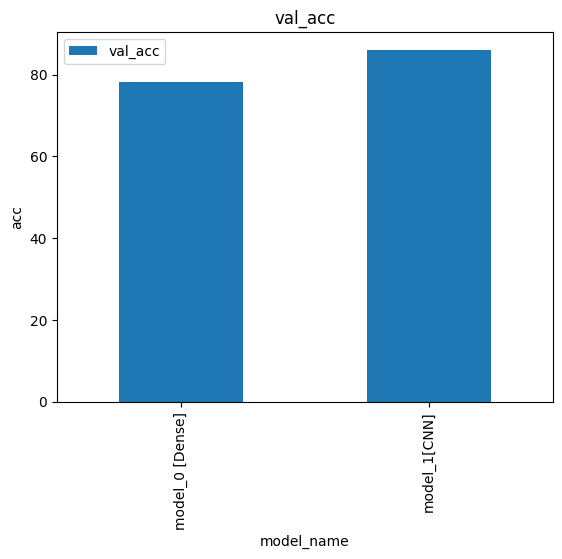

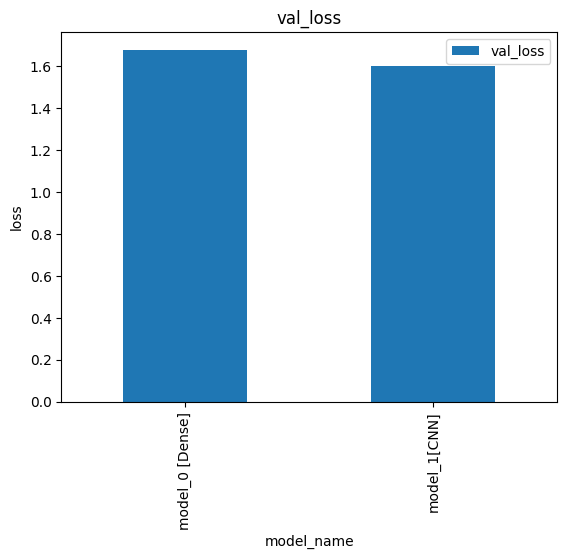

In [78]:
df[["val_acc"]].plot(kind="bar")
plt.title("val_acc")
plt.ylabel("acc")

df[["val_loss"]].plot(kind="bar")
plt.title("val_loss")
plt.ylabel("loss")
plt.show()

**Confusion Matrix**

In [94]:
test_dataset_1= datasets.FashionMNIST(root="data",
                                    train=False, #tets_data
                                    transform=ToTensor(),
                                    target_transform=None)

In [79]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
def confusion_matrix(model):
  y_preds_l=[]
  cm=ConfusionMatrix("multiclass", num_classes=len(class_names), normalize=None)
  for x, y in test_dataset:
    model.eval()
    with torch.inference_mode():

      y_pred_s=model(x)
      y_preds=y_pred_s.argmax(dim=1)
      y_preds_l.append(y_preds.cpu())
  y_preds_1=torch.cat(y_preds_l)

  fig, ax=plot_confusion_matrix(conf_mat=cm(y_preds_1, test_dataset_1.targets).numpy(), colorbar=True, show_normed= True, show_absolute=False)
  plt.show()

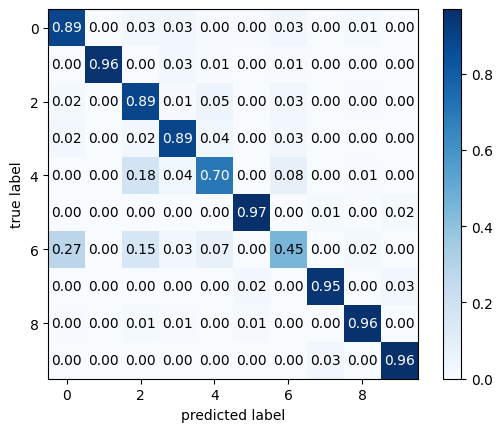

In [118]:
confusion_matrix(model_1)

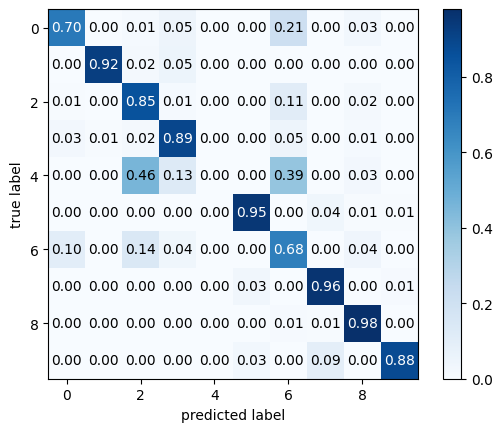

In [117]:
confusion_matrix(model_0)